### Hyper HYPER

#### Setup

### Tensorbaord Data

In [1]:
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


# Extraction function
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

In [2]:
df = tflog2pandas("/home/kokkgoblin/Code/hyper-nn/notebooks/tensorboard_logs/CIFAR10_TorchTargetNetwork_2022-05-04 13:26:07.063256")

In [3]:
import numpy as np

In [4]:
df[df["metric"] == "loss"]

,metric,value,step
0,loss,2.414503,0.0
1,loss,3.883799,1.0
2,loss,3.568160,2.0
3,loss,4.414857,3.0
4,loss,4.227792,4.0
...,...,...,...
495,loss,1.856543,495.0
496,loss,1.882748,496.0
497,loss,1.823943,497.0
498,loss,1.871331,498.0


In [5]:
def get_accuracy_loss(path: str):
    df = tflog2pandas(path)
    return np.array(df[df["metric"] == "accuracy"]["value"]), np.array(df[df["metric"] == "loss"]["value"])

In [6]:
target_acc, target_loss = get_accuracy_loss("/home/kokkgoblin/Code/hyper-nn/notebooks/tensorboard_logs/CIFAR10_TorchTargetNetwork_2022-05-04 13:26:07.063256")

level1_acc, level1_loss = get_accuracy_loss('/home/kokkgoblin/Code/hyper-nn/notebooks/tensorboard_logs/CIFAR10_HypernetworkTorchLEVEL1_num_embeddings64_hiddendim82557_num_params413041_iterations500_2022-05-04 13:46:54.924302')
level2_acc, level2_loss = get_accuracy_loss('/home/kokkgoblin/Code/hyper-nn/notebooks/tensorboard_logs/CIFAR10_HypernetworkTorchLEVEL2_num_embeddings64_hiddendim11618_num_params58346_iterations500_2022-05-04 14:08:06.548585')
level3_acc, level3_loss = get_accuracy_loss('/home/kokkgoblin/Code/hyper-nn/notebooks/tensorboard_logs/CIFAR10_HypernetworkTorchLEVEL3_num_embeddings64_hiddendim1642_num_params8466_iterations500_2022-05-04 14:29:23.346215')
level4_acc, level4_loss = get_accuracy_loss('/home/kokkgoblin/Code/hyper-nn/notebooks/tensorboard_logs/CIFAR10_HypernetworkTorchLEVEL4_num_embeddings64_hiddendim239_num_params1451_iterations500_2022-05-04 14:50:43.351635')
level5_acc, level5_loss = get_accuracy_loss('/home/kokkgoblin/Code/hyper-nn/notebooks/tensorboard_logs/CIFAR10_HypernetworkTorchLEVEL5_num_embeddings32_hiddendim104_num_params648_iterations500_2022-05-04 15:12:04.348970')

In [7]:
x = np.arange(level1_acc.shape[0])

num target params: 5283594 \
Hypernetwork with level: 1, num_embeddings: 64, embedding_dim: 8, hidden_dim: 82557, num_parameters: 413041 \
Hypernetwork with level: 2, num_embeddings: 64, embedding_dim: 8, hidden_dim: 11618, num_parameters: 58346 \
Hypernetwork with level: 3, num_embeddings: 64, embedding_dim: 8, hidden_dim: 1642, num_parameters: 8466 \
Hypernetwork with level: 4, num_embeddings: 64, embedding_dim: 8, hidden_dim: 239, num_parameters: 1451 \
Hypernetwork with level: 5, num_embeddings: 32, embedding_dim: 4, hidden_dim: 104, num_parameters: 648 \

### Accuracy

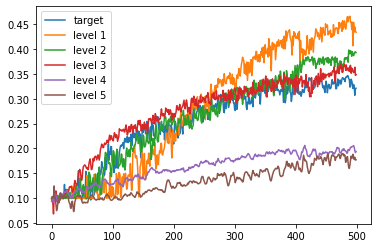

In [10]:
import matplotlib.pyplot as plt

plt.plot(x, target_acc, label = "target")
plt.plot(x, level1_acc, label = "level 1")
plt.plot(x, level2_acc, label = "level 2")
plt.plot(x, level3_acc, label = "level 3")
plt.plot(x, level4_acc, label = "level 4")
plt.plot(x, level5_acc, label = "level 5")
plt.legend()
plt.show()

### Loss

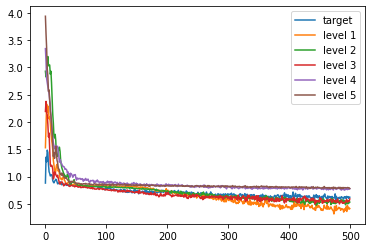

In [11]:
import matplotlib.pyplot as plt


plt.plot(x, np.log(target_loss), label = "target")
plt.plot(x, np.log(level1_loss), label = "level 1")
plt.plot(x, np.log(level2_loss), label = "level 2")
plt.plot(x, np.log(level3_loss), label = "level 3")
plt.plot(x, np.log(level4_loss), label = "level 4")
plt.plot(x, np.log(level5_loss), label = "level 5")
plt.legend()
plt.show()

#### Loading MNIST

In [ ]:
import os
import torchvision
import torchvision.transforms as transforms
## load mnist dataset

root = 'data'
if not os.path.exists(root):
    os.mkdir(root)

trans = transforms.Compose([transforms.ToTensor()])
# if not exist, download mnist dataset
train_set = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True)
test_set = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True)


In [ ]:
train_set[0][0].size()

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(train_set[i][0].detach().numpy().squeeze(), cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(train_set[i][1]))
    plt.xticks([])
    plt.yticks([])

In [ ]:
import torch

class TorchMNISTConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 512, 3, 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 10, 2, 2)
        )

    def forward(self, x):
        out = self.net(x).view(x.size(0), -1)
        return out

In [ ]:
torch_target_network = TorchMNISTConvNet()
pytorch_total_params = sum(p.numel() for p in torch_target_network.parameters() if p.requires_grad)
pytorch_total_params

In [ ]:
torch_target_network(torch.zeros(1,1,28,28)).size()

## Torch

In [ ]:
from hypernn.torch.static_hypernet import TorchHyperNetwork
from typing import Any, Optional

### Simple Embedding Module + Weight Generator

### Instantiating hypernetwork with Class definitions

In [ ]:
hypernetwork = TorchHyperNetwork.from_target(
    torch_target_network,
    embedding_dim=4,
    num_embeddings=1024
)

In [ ]:
import torch.nn as nn
from typing import Tuple, Dict, Optional

class RecursiveHyperNetwork(TorchHyperNetwork):
    def __init__(
        self,
        target_network: nn.Module,
        num_target_parameters: Optional[int] = None,
        embedding_dim: int = 100,
        num_embeddings: int = 3,
        hidden_dim: Optional[int] = None,
        *args, **kwargs
    ):
        super().__init__(
                    target_network = target_network,
                    num_target_parameters = num_target_parameters,
                    embedding_dim = embedding_dim,
                    num_embeddings = num_embeddings,
                    hidden_dim = hidden_dim,
                )
        # self.layer_norm = nn.LayerNorm([self.hidden_dim])

    def setup(self) -> None:
        if self.embedding_module is None:
            self.embedding_module = nn.Embedding(
                self.num_embeddings, self.embedding_dim
            )

        if self.weight_generator_module is None:
            self.weight_generator_module = nn.Sequential(
                nn.Linear(
                    self.embedding_dim, self.hidden_dim
                ),
            )

    def weight_generator(self, embedding: torch.Tensor) -> torch.Tensor:
        return self.weight_generator_module(embedding / embedding.max()).view(-1)


In [ ]:
def hyper_hyper(num_levels: int, target_network, embedding_dim, num_embeddings):
    t = target_network
    for i in range(num_levels - 1):
        hypernetwork = RecursiveHyperNetwork.from_target(
                    t,
                    embedding_dim=embedding_dim,
                    num_embeddings=num_embeddings
        )
        t = hypernetwork
    hypernetwork = RecursiveHyperNetwork.from_target(
                t,
                embedding_dim=4,
                num_embeddings=num_embeddings
    )
    return hypernetwork

In [ ]:
class HyperHyper(nn.Module):
    def __init__(self, num_levels, target_network, embedding_dim, num_embeddings):
        super().__init__()
        self.num_levels = num_levels
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.hypernetwork = hyper_hyper(num_levels, target_network, embedding_dim, num_embeddings)

    def forward(self, x):
        inp = x.to(self.hypernetwork.device)
        for i in range(self.num_levels - 1):
                inp = [inp]
        return self.hypernetwork(inp=[inp])

#### Train hypernetwork

In [ ]:
import os
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

def get_tensorboard_logger(
    experiment_name: str, base_log_path: str = "tensorboard_logs"
):
    log_path = "{}/{}_{}".format(base_log_path, experiment_name, datetime.now())
    train_writer = SummaryWriter(log_path, flush_secs=10)
    full_log_path = os.path.join(os.getcwd(), log_path)
    print(
        "Follow tensorboard logs with: python -m tensorboard.main --logdir '{}'".format(full_log_path)
    )
    return train_writer

In [ ]:
hyper_params = [
    (8, 64),
    (8, 64),
    (8, 64),
    (8, 64),
    (4, 32),
    (4, 32),

]

In [ ]:
from copy import deepcopy

def make_hyperhypers(hyper_params, target):
    hypers = []
    pytorch_total_params = sum(p.numel() for p in target.parameters() if p.requires_grad)
    print("num target params: {}".format(pytorch_total_params))
    for i in range(1, len(hyper_params)):
        hyper  = HyperHyper(i, deepcopy(target), hyper_params[i-1][0], hyper_params[i-1][1])
        pytorch_total_params = sum(p.numel() for p in hyper.parameters() if p.requires_grad)
        print("Hypernetwork with level: {}, num_embeddings: {}, embedding_dim: {}, hidden_dim: {}, num_parameters: {}".format(i, hyper.num_embeddings, hyper.embedding_dim, hyper.hypernetwork.hidden_dim, pytorch_total_params))
        hypers.append(hyper)
    return hypers

In [ ]:
import tqdm
import numpy as np

def random_sample(dataset, num_samples:int = 1):
    length = len(dataset)
    random_indices = np.random.randint(0,length, num_samples)
    return torch.stack([dataset[idx][0] for idx in random_indices]), torch.tensor([dataset[idx][1] for idx in random_indices])


In [ ]:
def train_network_mnist(network, name, train_set, test_set, num_iterations=500):
    print("STARTING", name)
        
    writer = get_tensorboard_logger(name)

    train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=512,
                 shuffle=True)
    test_loader = torch.utils.data.DataLoader(
                    dataset=test_set,
                    batch_size=512,
                    shuffle=False)        

    device = torch.device("cuda")
    network = network.to(device)

    optimizer = torch.optim.Adam(network.parameters(), lr=0.01)
    bar = tqdm.tqdm(np.arange(num_iterations))

    grad_dict = {}

    for i in bar:

        train_loss = []
        x, target = random_sample(train_set, 512)
        # for batch_idx, (x, target) in enumerate(train_loader):
        # for sample in samples:
        x = x.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        out = network(x)
        loss =  torch.nn.functional.cross_entropy(out, target)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(network.parameters(), 10.0)
        optimizer.step()

        train_loss.append(loss.item())

        avg_loss = np.mean(train_loss)

        num_correct = 0
        count = 0
        for batch_idx, (x, target) in enumerate(test_loader):
            count += x.size(0)
            with torch.no_grad():
                out = network(x.to(device))
                _, predicted = torch.max(out.detach(), -1)
            num_correct += (predicted.detach().cpu() == target.data).sum()
        accuracy = num_correct / count

        grad_dict = {}
        for n, W in network.named_parameters():
            if W.grad is not None:
                grad_dict["{}_grad".format(n)] = float(torch.sum(W.grad).item())

        metrics = {"loss":loss.item(), "accuracy":accuracy.item(), **grad_dict}

        for key in metrics:
            writer.add_scalar(key, metrics[key], i)

        bar.set_description("Loss: {}, Test Acc: {}".format(avg_loss, accuracy))
    return network, loss.item(), accuracy.item()

In [ ]:
def train_hyper_hyper(hypernetworks, torch_target_network, train_set, test_set, dataset_name="MNIST", num_iterations = 500):
    
    torch_target_network, loss, accuracy = train_network_mnist(torch_target_network, "{}_TorchTargetNetwork".format(dataset_name), train_set, test_set, num_iterations)
    device = torch.device("cpu")
    torch_target_network = torch_target_network.to(device)
    print("FINAL Metrics FOR TARGET NETWORK: Loss: {}, ACCURACY: {}".format(loss, accuracy))

    device = torch.device("cpu")
    torch_target_network = torch_target_network.to(device)

    for level in range(len(hypernetworks)):

        hypernetwork = hypernetworks[level]
        pytorch_total_params = sum(p.numel() for p in hypernetwork.parameters() if p.requires_grad)
        num_embeddings = hypernetwork.num_embeddings
        embedding_dim = hypernetwork.embedding_dim
        hidden_dim =  hypernetwork.hypernetwork.hidden_dim

        
        name = "{}_HypernetworkTorchLEVEL{}_num_embeddings{}_hiddendim{}_num_params{}_iterations{}".format(dataset_name, level+1, num_embeddings, hidden_dim, pytorch_total_params, num_iterations)
        hypernetwork, loss, accuracy = train_network_mnist(hypernetwork, name, train_set, test_set, num_iterations) 
        
        print("FINAL Metrics FOR HYPERNETWORK level {}: Loss: {}, Test accuracy: {}".format(level+1,  loss, accuracy))
        device = torch.device("cpu")
        hypernetwork = hypernetwork.to(device)
        hypernetworks[level] = hypernetwork
    return torch_target_network, hypernetworks

In [ ]:
# hypers = make_hyperhypers(hyper_params, torch_target_network)
# trained_target_network, hypers = train_hyper_hyper(hypers, torch_target_network, train_set, test_set)

#### Display subset of predictions

In [ ]:
# import matplotlib.pyplot as plt

# fig = plt.figure()
# for i in range(6):
#     out = hypernetwork(test_set[i][0].to(device))
#     _, predicted = torch.max(out.detach(), -1)
#     plt.subplot(2,3,i+1)
#     plt.imshow(test_set[i][0].detach().numpy().squeeze(), cmap='gray', interpolation='none')
#     plt.title("Prediction: {}".format(predicted.item()))
#     plt.xticks([])
#     plt.yticks([])
#     plt.tight_layout()

### Fashion MNIST

In [ ]:
root = 'data'
if not os.path.exists(root):
    os.mkdir(root)

trans = transforms.Compose([transforms.ToTensor()])
# if not exist, download mnist dataset
train_set = torchvision.datasets.FashionMNIST(root=root, train=True, transform=trans, download=True)
test_set = torchvision.datasets.FashionMNIST(root=root, train=False, transform=trans, download=True)


In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(train_set[i][0].detach().numpy().squeeze(), cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(train_set[i][1]))
    plt.xticks([])
    plt.yticks([])

In [ ]:
torch_target_network = TorchMNISTConvNet()
pytorch_total_params = sum(p.numel() for p in torch_target_network.parameters() if p.requires_grad)
pytorch_total_params

In [ ]:
# hypers = make_hyperhypers(hyper_params, torch_target_network)
# trained_target_network, hypers = train_hyper_hyper(hypers, torch_target_network, train_set, test_set, "FASHIONMNIST")

# Transfer learning!

In [ ]:
trans = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True)
test_set = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True)

In [ ]:
# torch_target_network = TorchMNISTConvNet()

# hypers = make_hyperhypers(hyper_params, torch_target_network)
# trained_target_network, hypers = train_hyper_hyper(hypers, torch_target_network, train_set, test_set, dataset_name="TransferMNIST", num_iterations=1000)

## Transfer to FashionMNIST

In [ ]:
trans = transforms.Compose([transforms.ToTensor()])
# if not exist, download mnist dataset
train_set = torchvision.datasets.FashionMNIST(root=root, train=True, transform=trans, download=True)
test_set = torchvision.datasets.FashionMNIST(root=root, train=False, transform=trans, download=True)

In [ ]:
# trained_target_network, hypers = train_hyper_hyper(hypers, torch_target_network, train_set, test_set, dataset_name="TransferFashionMNIST", num_iterations=500)

### CIFAR10

In [ ]:
trans = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10(root=root, train=True, transform=trans, download=True)
test_set = torchvision.datasets.CIFAR10(root=root, train=False, transform=trans, download=True)

#### Vision Transformer

In [ ]:

from vit_pytorch import ViT

import torch
torch.manual_seed(10)

torch_target_network = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 256,
    depth = 4,
    heads = 16,
    mlp_dim = 512,
    dropout = 0.0,
    emb_dropout = 0.0
)
pytorch_total_params = sum(p.numel() for p in torch_target_network.parameters() if p.requires_grad)
pytorch_total_params

In [ ]:
hypers = make_hyperhypers(hyper_params, torch_target_network)
trained_target_network, hypers = train_hyper_hyper(hypers, torch_target_network, train_set, test_set, dataset_name="CIFAR10_5000ITERS", num_iterations=5000)

In [ ]:

# from vit_pytorch import ViT

# import torch
# torch.manual_seed(0)

# torch_target_network = ViT(
#     image_size = 32,
#     patch_size = 4,
#     num_classes = 10,
#     dim = 256,
#     depth = 4,
#     heads = 16,
#     mlp_dim = 512,
#     dropout = 0.0,
#     emb_dropout = 0.0
# )
# pytorch_total_params = sum(p.numel() for p in torch_target_network.parameters() if p.requires_grad)
# pytorch_total_params

In [ ]:
# hypers = make_hyperhypers(hyper_params, torch_target_network)
# trained_target_network, hypers = train_hyper_hyper(hypers, torch_target_network, train_set, test_set, dataset_name="CIFAR10", num_iterations=500)

### LSTM Hypernetwork

In [ ]:
from typing import Any, Dict, List, Optional, Tuple, Type, Union  # noqa
import torch.nn as nn

class LSTMHypernetwork(TorchHyperNetwork):
    def __init__(
        self,
        target_network: nn.Module,
        num_target_parameters: Optional[int] = None,
        embedding_dim: int = 100,
        num_embeddings: int = 3,
        hidden_dim: Optional[int] = None,
        *args, **kwargs
    ):
        super().__init__(
                    target_network = target_network,
                    num_target_parameters = num_target_parameters,
                    embedding_dim = embedding_dim,
                    num_embeddings = num_embeddings,
                    hidden_dim = hidden_dim,
                )

    def make_embedding(self):
        embedding = nn.Parameter(torch.randn(1, self.embedding_dim).to(self.device))
        return embedding

    def make_weight_generator(self):
        return nn.GRUCell(self.embedding_dim, self.hidden_dim)

    def generate_params(
        self, inp = []
    ) -> Tuple[torch.Tensor, Dict[str, Any]]:
        embedding = self.embedding
        hidden = torch.zeros(1, self.hidden_dim, device=self.device)
        output = []
        for _ in range(self.num_embeddings):
            hidden = self.weight_generator(embedding, hidden)
            output.append(hidden)
        return torch.stack(output).view(-1), {}


In [ ]:
hypernetwork = LSTMHypernetwork.from_target(
    torch_target_network,
    embedding_dim=8,
    num_embeddings=7000
)

In [ ]:
pytorch_total_params = sum(p.numel() for p in hypernetwork.parameters() if p.requires_grad)
pytorch_total_params

In [ ]:
hypernetwork(inp=[torch.zeros((1,1,28,28), device=hypernetwork.device)])

In [ ]:
device = torch.device('cuda')
hypernetwork = hypernetwork.to(device)

In [ ]:
len(train_set)

In [ ]:
np.random.randint(0,100, 5)

In [ ]:
def random_sample(dataset, num_samples:int = 1):
    length = len(dataset)
    random_indices = np.random.randint(0,length, num_samples)
    return [dataset[idx] for idx in random_indices]

In [ ]:
import tqdm
import numpy as np

num_samples = 1

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=32,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=32,
                shuffle=False)

optimizer = torch.optim.Adam(hypernetwork.parameters(), lr=0.001)
bar = tqdm.tqdm(np.arange(1000))

for i in bar:

    train_loss = []
    samples = random_sample(train_set, num_samples)
    for sample in samples:
        x = sample[0].view(1, 1, 28, 28).to(hypernetwork.device)
        target = torch.tensor(sample[1]).view(1,).to(hypernetwork.device)
        optimizer.zero_grad()
        out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
        loss =  torch.nn.functional.cross_entropy(out.to(hypernetwork.device), target.to(hypernetwork.device))
        print("SHIT")
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    avg_loss = np.mean(train_loss)
    num_correct = 0
    count = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        count += x.size(0)
        with torch.no_grad():
            out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
            _, predicted = torch.max(out.detach(), -1)
        num_correct += (predicted.detach().cpu() == target.data).sum()
    accuracy = num_correct / count
    bar.set_description("Loss: {}, Test Acc: {}".format(avg_loss, accuracy))


## Jax

In [ ]:
# uncomment this to enable jax gpu preallocation, might lead to memory issues

import os
import jax
import jax.numpy as jnp

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [ ]:
import flax.linen as linen

In [ ]:
class JaxMNISTConvNet(linen.Module):

    @linen.compact
    def __call__(self, x):
        x = linen.Conv(64, kernel_size=(3,3), strides=2, padding="VALID")(x)
        x = linen.relu(x)
        x = linen.Conv(64, kernel_size=(3,3), strides=2, padding="VALID")(x)
        x = linen.relu(x)
        x = linen.Conv(64, kernel_size=(3,3), strides=2, padding="VALID")(x)
        x = linen.relu(x)
        x = linen.Conv(10, kernel_size=(2,2), strides=2, padding="VALID")(x)
        x = x.reshape(x.shape[0], -1)
        x = linen.log_softmax(x)
        return x

In [ ]:
jax_target_network = JaxMNISTConvNet()

In [ ]:
from hypernn.jax.utils import count_jax_params

count_jax_params(jax_target_network, inputs=[jnp.zeros((64,64,1))])

#### Simple Jax Hypernetwork

In [ ]:
from typing import Optional, Any, Dict

from hypernn.jax.embedding_module import FlaxEmbeddingModule
from hypernn.jax.weight_generator import FlaxWeightGenerator
from hypernn.jax.hypernet import FlaxHyperNetwork


class CustomFlaxEmbeddingModule(FlaxEmbeddingModule):
    def setup(self):
        self.embedding = linen.Embed(self.num_embeddings, self.embedding_dim)

    def __call__(self, inp: Optional[Any] = None):
        indices = jnp.arange(0, self.num_embeddings)
        return self.embedding(indices), {}

class CustomFlaxWeightGenerator(FlaxWeightGenerator):
    def setup(self):
        self.dense1 = linen.Dense(32)
        self.dense2 = linen.Dense(self.hidden_dim, use_bias=False)

    def __call__(self, embedding, inp: Optional[Any] = None):
        x = self.dense1(embedding)
        x = linen.tanh(x)
        x = self.dense2(x)
        return x.reshape(-1), {}


### Making hypernetwork with `embedding_dim = 4` and `num_embeddings = 1024`

In [ ]:
jax_hyper = FlaxHyperNetwork.from_target(
    target_network=jax_target_network,
    inputs=[jnp.zeros((28,28,1))],
    embedding_module=CustomFlaxEmbeddingModule,
    weight_generator=CustomFlaxWeightGenerator,
    embedding_dim = 4,
    num_embeddings = 1024
)

In [ ]:
count_jax_params(jax_hyper, inputs=[[jnp.zeros((28,28,1))]])

### Training MNIST

#### Creating train state

In [ ]:
import optax
from flax.training import train_state  # Useful dataclass to keep train state

def create_hyper_train_state(rng, model, learning_rate):
    """Creates initial `TrainState`."""
    params = model.init(rng, [jnp.zeros((28,28,1))])['params']
    tx = optax.chain(
        optax.adam(learning_rate)
    )
    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=tx
    )

#### Update step

In [ ]:
def cross_entropy_loss(logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

In [ ]:
import functools

@jax.jit
def compute_metrics(logits, labels):
    loss = cross_entropy_loss(logits=logits, labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics

@functools.partial(jax.jit, static_argnames=('apply_fn'))
def train_step(apply_fn, state, x, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = apply_fn({'params': params}, inp=[x], has_aux=False)
        loss = cross_entropy_loss(logits=logits, labels=targets)
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits=logits, labels=targets)
    return state, metrics

In [ ]:
import tqdm
import numpy as np
from einops import rearrange

bar = tqdm.tqdm(np.arange(1000))

rng = jax.random.PRNGKey(0)
state = create_hyper_train_state(rng, jax_hyper, 0.0002)

for i in bar:

    train_loss = []
    for batch_idx, (x, target) in enumerate(train_loader):
        x = rearrange(jnp.array(x.numpy()), 'b c w h -> b w h c')
        target = jnp.array(target.numpy())

        state, metrics = train_step(jax_hyper.apply, state, x, target)
        loss = metrics["loss"]
        # optimizer.zero_grad()
        # out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
        # loss =  torch.nn.functional.cross_entropy(out.to(hypernetwork.device), target.to(hypernetwork.device))
        # loss.backward()
        # optimizer.step()

        train_loss.append(loss.item())

    avg_loss = np.mean(train_loss)
    num_correct = 0
    count = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        x = rearrange(jnp.array(x.numpy()), 'b c w h -> b w h c')
        count += x.shape[0]
        logits = jax_hyper.apply({"params":state.params}, inp=[x], has_aux=False)
        # with torch.no_grad():
        #     out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
        #     _, predicted = torch.max(out.detach(), -1)
        num_correct += jnp.sum(jnp.argmax(logits, -1) == target.numpy())
    accuracy = num_correct / count
    bar.set_description("Loss: {}, Test Acc: {}".format(avg_loss, accuracy))


In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    out = hypernetwork(inp=[test_set[i][0].to(hypernetwork.device)], has_aux=False)
    _, predicted = torch.max(out.detach(), -1)
    plt.subplot(2,3,i+1)
    plt.imshow(test_set[i][0].detach().numpy().squeeze(), cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(predicted.item()))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()